In [92]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from scipy.sparse import issparse
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [93]:
# Load dataset
df = pd.read_csv("../data/synthetic_users_dataset_2000.csv")
# df = pd.read_csv("synthetic_users_dataset_updated.csv")
X = df.drop(columns=[
    "severity_score",
    "severity_class"
])
y_true = df["severity_score"].values
print(np.unique(y_true))
X.head()

[1 2 3 4 5]


,pain_type,radiates,duration,self_score,sleep_score,activity_score,mood_score
0,dull,no,today,5,5,5,5
1,throbbing,yes,several days ago,5,5,5,5
2,burning,no,today,5,5,5,4
3,sharp,no,today,5,4,5,5
4,dull,no,today,5,5,4,5


### Data Preprocessing

In [94]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include="number").columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", OrdinalEncoder(), numerical_cols),
    ]
)

X_processed = preprocessor.fit_transform(X)
if issparse(X_processed):
    X_processed = X_processed.toarray()

print(f"Shape of X_processed: {X_processed.shape}")

le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true)  # maps 1→0, 2→1, ..., 5→4

Categorical columns: ['pain_type', 'radiates', 'duration']
Numerical columns: ['self_score', 'sleep_score', 'activity_score', 'mood_score']
Shape of X_processed: (2000, 15)


### t-SNE Plot Function

In [95]:
def plot_tsne(X_processed, y_pred, model_name, ax, legend_title=None):
    tsne = TSNE(n_components=2, random_state=42, perplexity=100)
    # tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_processed)
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=y_pred,
        palette="Set1",
        marker="o",
        s=30,
        edgecolor="none",
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"{model_name} - t-SNE")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(
        title=legend_title if legend_title else "Cluster",
        loc="upper right",
        fontsize="small"
    )

### Confusion Matrix Plot Function

In [96]:
# Create confusion matrix
def plot_confusion_matrix(y_true, y_pred_aligned, model_name, ax):
    cm = confusion_matrix(y_true, y_pred_aligned)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model_name} - Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

In [97]:
# Plot t-SNE for orignial dataset
# fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# plot_tsne(X_processed, y_true, "Original Dataset", ax, legend_title="True\nSeverity\nScore")
# plt.tight_layout()
# plt.show()

In [98]:
# Define clustering models
models = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "GMM": GaussianMixture(n_components=5, random_state=42),
    "Spectral": SpectralClustering(n_clusters=5, random_state=42),
}

In [99]:
# ----Hungrarian method----
def remap_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = dict(zip(col_ind, row_ind))
    return np.array([mapping.get(label, -1) for label in y_pred])

### Training

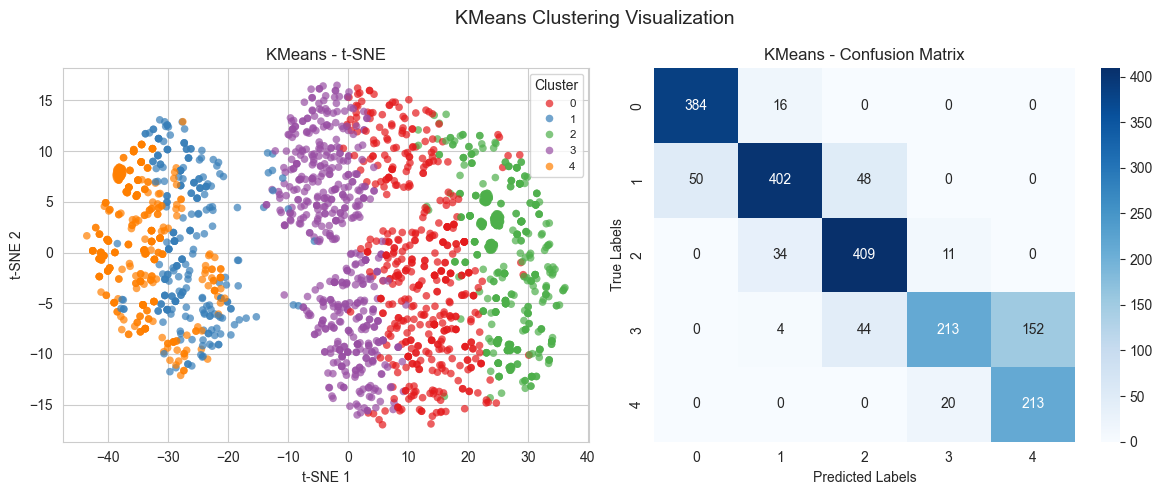

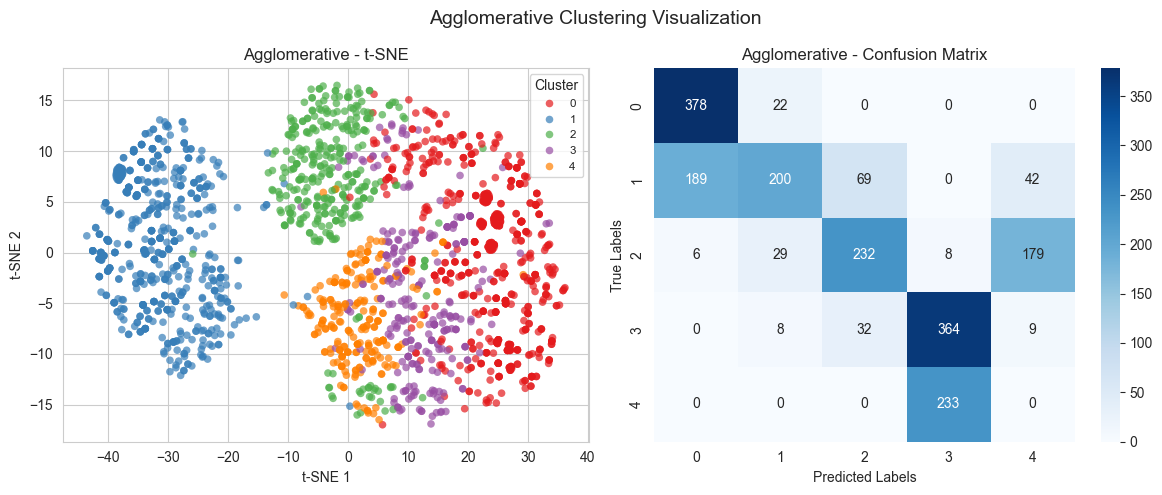

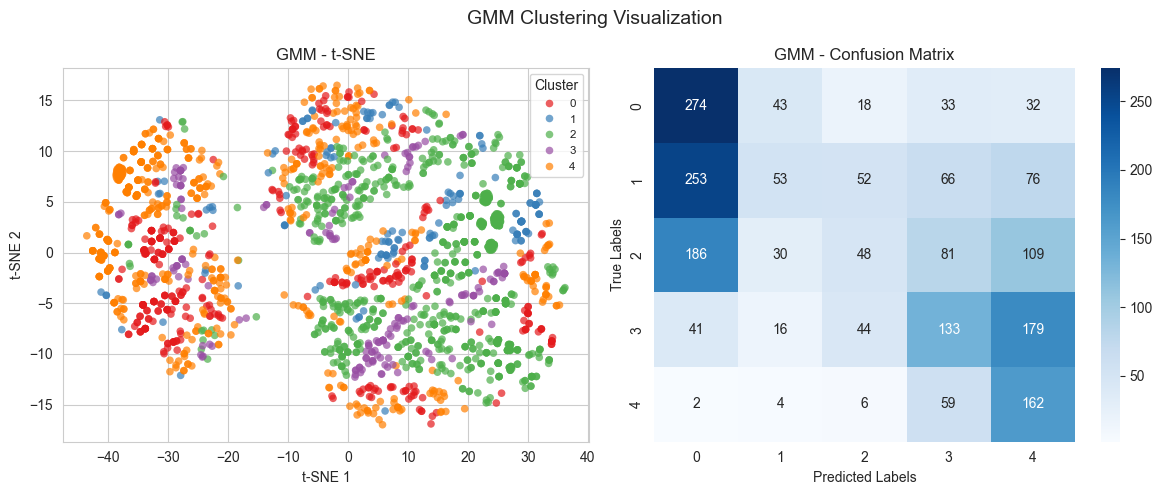

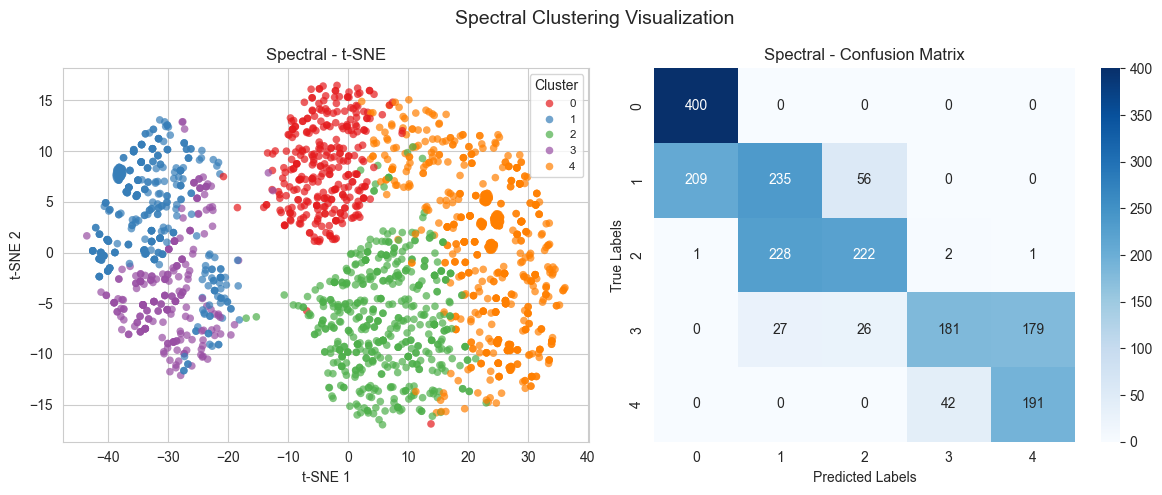

In [100]:
# Training

results = []
# for n_components in [2]:
for name, model in models.items():
    # pca = PCA(n_components=6, random_state=42)
    # X_pca = pca.fit_transform(X_processed)

    if name == "GMM":
        y_pred = model.fit_predict(X_processed)
    else:
        y_pred = model.fit(X_processed).labels_

    # n_clusters_pred = len(set(y_pred)) - (1 if -1 in y_pred else 0)
    n_clusters_pred = len(set(y_pred))

    if n_clusters_pred != 5:
        ari = nmi = sil = coh = None
    else:
        y_aligned = remap_labels(y_true_encoded, y_pred)

        # Evaluation metrics
        ari = round(adjusted_rand_score(y_true_encoded, y_aligned), 4)
        nmi = round(normalized_mutual_info_score(y_true_encoded, y_aligned), 4)
        sil = round(silhouette_score(X_processed, y_pred), 4)
        kap = round(cohen_kappa_score(y_true_encoded, y_aligned), 4)

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # 1. plot t-SNE
    plot_tsne(X_processed, y_pred, name, axs[0])
    # 2. plot confusion matrix
    plot_confusion_matrix(y_true_encoded, y_aligned, name, axs[1])
    fig.suptitle(f"{name} Clustering Visualization", fontsize=14)
    plt.tight_layout()
    plt.show()

    results.append({
        "Model": name,
        "Clusters": n_clusters_pred,
        "Cohen's Kappa Score": kap,
        "Silhouette": sil,
        "ARI": ari,
        "NMI": nmi,
    })

In [101]:
# Convert to DataFrame and display
results_df = pd.DataFrame(results)
results_df

,Model,Clusters,Cohen's Kappa Score,Silhouette,ARI,NMI
0,KMeans,5,0.7620,0.1527,0.6353,0.6740
1,Agglomerative,5,0.4816,0.1884,0.4432,0.5513
2,GMM,5,0.1852,0.0097,0.0992,0.1272
3,Spectral,5,0.5172,0.1681,0.4112,0.5513


### 📊 Interpretation Guide

#### 🔷 Adjusted Rand Index (ARI)

| ARI Score Range   | Interpretation              |
|-------------------|-----------------------------|
| **0.80 – 1.00**   | 💎 Almost perfect clustering structure |
| **0.60 – 0.79**   | ✅ Strong clustering agreement        |
| **0.40 – 0.59**   | ⚠️ Moderate structure alignment       |
| **0.20 – 0.39**   | ❓ Weak or partial structure alignment |
| **0.00 – 0.19**   | ❌ Minimal or no agreement             |
| **< 0.00**        | 🔥 Worse than chance clustering        |

---

#### 🟢 Cohen’s Kappa Score

| Kappa Score Range | Interpretation              |
|-------------------|-----------------------------|
| **0.80 – 1.00**   | 💎 Almost perfect agreement  |
| **0.60 – 0.79**   | ✅ Substantial agreement      |
| **0.40 – 0.59**   | ⚠️ Moderate agreement         |
| **0.20 – 0.39**   | ❓ Fair agreement             |
| **0.00 – 0.19**   | ❌ Slight or no agreement     |
| **< 0.00**        | 🔥 Worse than chance          |


In [102]:
# Best model (based on the coherence between predicted labels and ground-truth labels)
best_model = results_df.loc[results_df["Cohen's Kappa Score"].idxmax()]
best_model

Model                  KMeans
Clusters                    5
Cohen's Kappa Score     0.762
Silhouette             0.1527
ARI                    0.6353
NMI                     0.674
Name: 0, dtype: object